In [84]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import cauchy
import scipy.stats as stats
import math
from sklearn.preprocessing import Normalizer
import sys
import ffht
from hashlib import md5
import timeit
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.metrics import euclidean_distances

mbyte = 1048576
norm_l2 = Normalizer(norm='l2')
norm_l1 = Normalizer(norm='l1')

# Tools


In [72]:
from hashlib import md5

def hybrid_dist(x, y, d_max, verbose=False):
    """
    Args:
        x1, y1: hamming 距离向量
        x2, y2: 欧式距离向量
        verbose: 显示详细内容
    """
    hd = distance.hamming(x[0], y[0])
    ed = distance.euclidean(x[1], y[1]) / d_max
    hybrid_d = 0.5 * hd + 0.5 * ed
    
    if verbose is True:
        print('hamming dist = {:.4f}, euclidean dist = {:.4f}'.format(hd, ed))
        print('hybrid dist = {}'.format(hybrid_d))
        
    return hybrid_d

def R(P):
    max_p = P.max(axis=0)
    min_p = P.min(axis=0)
    R = np.sqrt(np.sum((max_p - min_p) ** 2))
    return R / 2

def gram_schmidt(A):
    """
    Desc:
        Gram-schmidt正交化
        将所矩阵正交化
    """
    Q=np.zeros_like(A)
    cnt = 0
    for a in A.T:
        u = np.copy(a)
        for i in range(0, cnt):
            u -= np.dot(np.dot(Q[:, i].T, a), Q[:, i]) # 减去待求向量在以求向量上的投影
        e = u / np.linalg.norm(u)  # 归一化
        Q[:, cnt] = e
        cnt += 1
    R = np.dot(Q.T, A)
    return Q

def generate_md5(H):
    """
    Desc:
        md5 编码
    """
    hmd5 = md5()
    hmd5.update(str(H).encode(encoding='utf-8'))
    return hmd5.hexdigest()

def transform_hybrid(P1, P2, d):
    return np.append(P1, P2).reshape(2, -1).T.reshape(-1, 2, d)

In [58]:
a = np.array([1, 1, 1])
b = np.array([0, 0, 0])

In [71]:
np.append(a, b).reshape(2, -1).T.reshape(-1, 2, 1)

array([[[1],
        [0]],

       [[1],
        [0]],

       [[1],
        [0]]])

# 实验指标

参数对比：
- 查询时间和准确度的权衡
- 查询时间和候选数量的权衡
- 准确度与空间消耗的权衡

算法对比：
- 查询时间的对比
- 准确度的对比
- 空间消耗对比
- 候选数量对比

## 召回率

In [ ]:
def recall(P, query_func, args, test_P, test_name):
    test_n = len(test_P)
    recall = 0
    for i in range(test_n):
        result = query_func(P, args, test_P[i])
        if len(result) == 0:
            continue
        call = len(np.intersect1d(result, near_neighbors[test_name][i]))
        if len(near_neighbors[test_name][i]) == 0:
            continue
        recall += (call / len(near_neighbors[test_name][i]))

    print('query {} points'.format(test_n))
    print(recall, test_n)
    return recall / test_n

## 查询时间

In [ ]:
import timeit

def query_time(P, query_func, args, test_P, test_name):
    
    test_n = 100
    t1 = timeit.default_timer()
    for i in range(test_n):
        result = query_func(P, args, P[i])
    t2 = timeit.default_timer()

    t = (t2 - t1 + 0.0) 
    print('query {} points cost {} s, avg {} s'.format(test_n, t, t / test_n))
    
    return t

In [ ]:
def hybird_query_time(P, query_func, args, test_P, test_name):
    return query_time(P, query_func, args, test_P, test_name)

线性搜索

In [ ]:
def linear_query(P, args, q):
    n = P.shape[0]
    
    q_dist = np.array([euclidean_dist(q, P[i]) for i in range(n)])
    best_index = np.argsort(q_dist)[1]
    best_dist = q_dist[best_index]

    return best_index

### 查找到最近邻的时间

In [ ]:
def hybird_find_nearest_time(P, query_func, args, test_P, test_name):
    correct = 0
    n = P.shape[0]
    d = P.shape[2]
    t = 0.0
    test_n = test_P.shape[0]
    for i, q in enumerate(test_P):
        t1 = timeit.default_timer()
        result = query_func(P, args, q)
        if len(result) == 0:
            continue
        q_dist = np.array([hybird_dist(q, p, dmax[test_name]) for p in P[result]])
        if len(q_dist) == 0:
            continue
        best_index = result[np.argsort(q_dist)[0]]
        t2 = timeit.default_timer()
        if best_index == nearest_neighbor[test_name][i]:
            t += (t2 - t1)
            correct += 1

    print('test {} points, and {} points can find the nearest neighbor.'.format(test_n, correct))
    print('score is {:.4f}'.format(correct / test_n))
    print('avg cost {} s can find the nearest neighbor.'.format(t / correct))
    return t / correct

## 准确度

In [ ]:
def hybird_std_accuracy(P, query_func, args, test_P, test_name):
    n = P.shape[0]
    total = 0
    d = P.shape[2]
    test_n = test_P.shape[0]
    correct = 0
    for i, q in enumerate(test_P):
        result = query_func(P, args, q)
        total += len(np.intersect1d(result, near_neighbors[test_name][i])) / len(result)
        if np.sum(result == nearest_neighbor[test_name][i]) != 0:
            correct += 1
    print('test {} points, and {} points can find the nearest neighbor.'.format(test_n, correct))

    return total / test_n

In [ ]:
def hybird_accuracy(P, query_func, args, test_P, test_name):
    correct = 0
    n = P.shape[0]
    total = 0
    d = P.shape[2]
    test_n = test_P.shape[0]

    for i, q in enumerate(test_P):
        result = query_func(P, args, q)
        total += len(result)
        if nearest_neighbor is not None and test_name in nearest_neighbor:
            best_index = nearest_neighbor[test_name][i]
        else:
            q_dist = np.array([hybird_dist(q, P[i], dmax[test_name]) for i in range(n)])
            best_index = np.argsort(q_dist)[0]
            best_dist = q_dist[best_index]
        if np.sum(result == best_index) != 0:
            correct += 1

    print('test {} points, and {} points can find the nearest neighbor.'.format(test_n, correct))
    print('avg search {} points can find the nearest neighbor.'.format(total / test_n))
    print('score is {:.4f}'.format(correct / test_n))
    return correct / test_n

In [ ]:
def accuracy(P, query_func, args, test_n=100, distance_function='euclidean', test_P=None):
    """
    Desc:
        随机抽取一定数量数据，评估算法的准确度
    Args:
        P: 点集
        query_func:
            Args:
                P,
                args,
                q
        args
    """
    correct = 0
    n = P.shape[0]
    total = 0
    if test_P is None:
        test_idxs = np.random.choice(np.arange(n), test_n, replace=False)
        for i in test_idxs:
            q = P[i]
            result = query_func(P, args, q)
            total += len(result)
            
            if distance_function == 'euclidean':
                q_dist = np.array([euclidean_dist(q, P[j]) for j in range(n)])
            elif distance_function == 'hamming':
                q_dist = np.array([hamming_dist(q, P[j]) for j in range(n)])
            best_index = np.argsort(q_dist)[1]
            best_dist = q_dist[best_index]
        
            if np.sum(result == best_index) != 0:
                correct += 1
    else:
        test_n = test_P.shape[0]
        for q in test_P:
            result = query_func(P, args, q)
            total += len(result)
            if distance_function == 'euclidean':
                q_dist = np.array([euclidean_dist(q, P[j]) for j in range(n)])
            elif distance_function == 'hamming':
                q_dist = np.array([hamming_dist(q, P[j]) for j in range(n)])

            best_index = np.argsort(q_dist)[0]
            best_dist = q_dist[best_index]

            if np.sum(result == best_index) != 0:
                correct += 1
    
    print('test {} points, and {} points can find the nearest neighbor.'.format(test_n, correct))
    print('avg search {} points can find the nearest neighbor.'.format(total / test_n))
    print('score is {:.4f}'.format(correct / test_n))
    return correct / test_n

## 汇总

In [13]:
def metrics(P, query_func, args, test, exact_nearest_neighbor, exact_k_near_neighbors, verbose=False):
    """
    Desc:
        评估
            1. 查询到最近邻的概率
            2. 准确率(现更改为错误率 error_ratio)
            3. 召回率
            4. 候选集数量(现改成 selectivity, 候选数量/数据集大小)
            5. 哈希时间
            6. 查询时间(最近邻)
            7. 空间消耗由于不同方法存储结构不同，放至函数体外
    Args:
        P: 数据集
        query_func: 查询函数
        args: 查询函数所需参数
        test: 测试集
        exact_nearest_neighbor: 精确的最近邻
        exact_k_near_neighbors: 精确的k-近邻
    """
    n = P.shape[0]
    K = 50 # k近邻
    correct = 0
    hash_times = 0.0
    total_times = 0.0
    n_test = 0
    recall = 0.0
    error_ratio = 0.0
    selectivity = 0.0
    
    for i, q in enumerate(test):
        
        t1 = timeit.default_timer()
        candidates = query_func(args, q)
        t2 = timeit.default_timer()
        
        if len(candidates) < K: # 排除异常点
            continue
        
        hash_times += (t2 - t1 + 0.0) # 5.
        selectivity += len(candidates) / n # 4.
        
        t1 = timeit.default_timer()
        candidates_dist = np.array([hybrid_dist(q, P[idx], dmax) for idx in candidates])
        nearest_neighbor_idx = candidates[np.argsort(candidates_dist)[0]]        
        t2 = timeit.default_timer()
        
        total_times += (t2 - t1 + 0.0) # 6.
        
        if nearest_neighbor == exact_nearest_neighbor[i]:
            correct += 1

        k_near_neighbors = candidates[np.argsort(candidates_dist)[:K]]
        n_correct_k = len(np.intersect1d(exact_k_near_neighbors[i], k_near_neighbors))
        
        recall += n_correct_k / K # 3 召回率
        error_ratio += np.array([distance.hybrid_dist(q, P[exact_k_near_neighbors[idx]]) / 
                 distance.hybrid_dist(q, P[k_near_neighbors[idx]]) for idx in range(K)]).sum() / K # 2. 错误率        
        
        n_test += 1 # 有效测试点数量
        
    pr = correct / n_test # 1
    error_ratio = error_ratio / n_test # 2
    recall = recall / n_test # 3
    selectivity = selectivity / n_test # 4
    hash_times = hash_times / n_test # 5
    total_times = (total_times + hash_times) / n_test # 6
    
    if verbose is True:
        print('The probability of find the nearest neighbor is {:.4f}'.format(pr))
        print('Error ratio: {:.4f}, Recall: {:.4f}, Selectivity: {:.4f}'.format(error_ratio, 
                                                                                recall, 
                                                                                selectivity))
        print('Hash time: {:.4f}, total time: {:.4f}'.format(hash_times, total_times))

    return pr, error_ratio, recall, selectivity, hash_times, total_times

# Datasets

In [42]:
K = 50

In [27]:
dic_nearest_neighbor = dict()
dic_k_near_neighbors = dict()
dmax = dict()

In [28]:
train = np.loadtxt('../synset/OPRCP/synset-1e4d128-train.csv').reshape([-1, 2, 128])
test = np.loadtxt('../synset/OPRCP/synset-1e4d128-test.csv').reshape([-1, 2, 128])
dataset_title = '1e4d128'

In [39]:
dmax[dataset_title] = euclidean_distances(train[:, 1, :]).max()

In [49]:
nearest_neighbor = []
k_near_neighbors = []
for q in test[:100]:
    ds = np.array([hybrid_dist(q, p, dmax[dataset_title]) for p in train])
    order_ds_args = np.argsort(ds)
    nearest_neighbor.append(order_ds_args[0])
    k_near_neighbors.append(order_ds_args[:K])
    
dic_nearest_neighbor[dataset_title] = nearest_neighbor
dic_k_near_neighbors[dataset_title] = k_near_neighbors

In [50]:
k_near_neighbors

[array([7974, 3373, 3524, 3495,  287,  275, 3201, 8501, 7008, 3907, 2093,
        6418, 1328, 7160, 6175, 5807,  974, 4491,  667, 4731, 2729, 3942,
        2413, 5840, 5249, 5482, 6312, 4792, 2198,  641, 6348, 2501, 8331,
        3758, 4429, 1113, 1240, 7554, 6878, 1804, 6049, 6712, 8602,  430,
        7828, 2605, 4301, 1176, 7734, 5771]),
 array([5202, 5035, 8560,  576, 4777, 2492, 4477,  126, 7509,  593, 6994,
        4903, 3759, 3486, 4712, 7588,  433, 8228, 8527, 2187, 5257, 8008,
        2013, 8630, 8365, 7131, 6804, 8056, 4225,  477, 8831, 8909,  395,
        1237, 6188, 7540, 5915, 4454, 7769, 6720, 1011, 8212, 4683,  949,
        5540, 2838, 7059, 3967, 5427, 6020]),
 array([5982, 3682, 2719, 7260,  674,  388, 1249, 8942, 8235,  578, 3651,
        8246, 7481, 2754,  754, 8476,  211, 4263, 5148, 8506, 1964, 4081,
        1518, 1795, 3390, 7767, 7228, 2639,  372, 2419, 8970, 8787, 7897,
        4971, 1653, 8790, 3407, 3143, 8345, 7853, 8893, 4798, 8100, 4226,
        7640, 1821, 

# 对比函数

## OPRCP

In [ ]:
def generate_cross_polytope(d, random_state=None):
    """
    Desc:
        生成正轴型 d 维, 2 * d 个
    """
    if random_state is not None:
        np.random.seed(random_state)
    A = np.random.normal(0, 1, (d, d))
    A = norm_l2.fit_transform(gram_schmidt(A))
    A = np.append(A, -A).reshape(-1, d)
    return A

#### 参数类

In [ ]:
def OPRCP(P, k, L, random_state=None):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
        
    """
    n = P.shape[0]
    d = P.shape[2]
    sd = int(d / k)
    C = math.ceil(d / k + L) + 2
    P1 = P[:, 0].copy()
    P2 = P[:, 1].copy()
    center = np.mean(P2, axis=0)
    P2 = P2 - center
    P2 = norm_l2.fit_transform(P2)

    print('k = {}, L = {}'.format(k, L))
    print('Every segament length is {}'.format(sd))

    buckets = []

    seeds = np.random.choice(np.arange(k * L * d), L, replace=False)
    one_segament_vector = list(range(sd, 0, -1))
    auxiliary_vector = np.array(one_segament_vector * k)
    e = generate_cross_polytope(d, random_state) # 生成正轴型向量 2 * d 个
    As = np.array([norm_l2.fit_transform(A) for A in np.random.normal(0, 1, (L, d, d))]) # 生成辅助旋转矩阵
    idxs = np.arange(n)

    for i in range(L):
        bucket = dict()

        A = As[i]
        rotate = norm_l2.fit_transform([A.dot(p) for p in P2]) # 加速
        H2 = rotate.dot(e.T).argmax(axis=1)

        for idx, p in enumerate(P):

            np.random.seed(seeds[i])
            php = np.random.permutation(p[0])

            H1 = -((auxiliary_vector * php).reshape(-1, sd).max(axis=1) - sd)
            H1[H1 == sd] = -1

            for j, h in enumerate(H1):
                if h == -1:
                    nj = j
                    while H1[nj] == -1:
                        nj = (1 + nj) % k
                    H1[j] = H1[nj] + C

            H = np.append(H1, H2[idx])
            # print(H)
            bi = generate_md5(H)
            if bi not in bucket:
                bucket[bi] = [idx]
            else:
                bucket[bi].append(idx)
       #  print(i)
        buckets.append(bucket)

    return center, e, As, transform_hybird(P1, P2), seeds, auxiliary_vector, buckets

单层存储空间缩小

#### 查询函数

In [ ]:
def OPRCP_query(P, args, q, candidate=False):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
    """
    center, e, As, P_, seeds, auxiliary_vector, buckets = args[0]
    m = args[1]
    k, L = args[2]
    
    n = P.shape[0]
    d = P.shape[2]
    C = math.ceil(d / k + L) + 2
    sd = int(d / k)
    q1 = q[0].copy()
    # 正则化至单位球面
    q2 = q[1].copy()
    q2 = q2 - center
    q2 = norm_l2.fit_transform([q2])[0]

    result = []

    for i in range(L):
        bucket = dict()

        np.random.seed(seeds[i])
        q1_ = np.random.permutation(q1)
        H1 = -((auxiliary_vector * q1_).reshape(-1, sd).max(axis=1) - sd)
        H1[H1 == sd] = -1

        for j, h in enumerate(H1):
            if h == -1:
                nj = j
                while H1[nj] == -1:
                    nj = (1 + nj) % k
                H1[j] = H1[nj] + C
        
        # print(H1)
        rotate = norm_l2.fit_transform([As[i].dot(q2)])[0]
        H2 = rotate.dot(e.T).argsort()[::-1][:m]
        
        for h2 in H2:
            H = np.append(H1, h2)
            # print(H)
            bi = generate_md5(H)
            if bi in buckets[i]:
                result.append(buckets[i][bi])

    if len(result) != 0:
        result = np.unique(np.concatenate(result))

    if candidate is True:
        return len(result)
    return result

### 测试

In [ ]:
train = hybird_train_1e4d1024
test = hybird_test_1e4d1024
name = '1e4d1024'

In [ ]:
%%time
k = 4
L = 34
m = 2
oprcp = OPRCP(train, k=k, L=L)

In [ ]:
m = 3

In [ ]:
center, e, As, P_, seeds, auxiliary_vector, buckets = oprcp

In [ ]:
size = 0
for bucket in buckets:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, OPRCP_query, [oprcp, m, (k, L)],
                test_P=test[:100], test_name=name)
time = hybird_query_time(train, OPRCP_query, [oprcp, m, (k, L)],
                test_P=test[:100], test_name=name)
nearest_time = hybird_find_nearest_time(train, OPRCP_query, [oprcp, m, (k, L)],
                test_P=test[:100], test_name=name)
number = candidate(train, OPRCP_query, [oprcp, m, (k, L)],
                test_P=test[:100], test_name=name)
rc = recall(train, OPRCP_query, [oprcp, m, (k, L)],
                test_P=test[:100], test_name=name)

print('\nTLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

In [ ]:
std_acc = hybird_std_accuracy(train, OPRCP_query, [oprcp, m, (k, L)],
                test_P=test[:100], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('std_acc = {}, f1 score = {}'.format(std_acc, f1))

## OPRCP version 3

### 处理

In [ ]:
def generate_cross_polytope(d, random_state=None):
    """
    Desc:
        生成正轴型 d 维, 2 * d 个
    """
    if random_state is not None:
        np.random.seed(random_state)
    A = np.random.normal(0, 1, (d, d))
    A = norm_l2.fit_transform(gram_schmidt(A))
    A = np.append(A, -A).reshape(-1, d)
    return A

In [ ]:
def OPRCP3(P, k, L, m, num_rotations=3, random_state=None):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
        
    """
    n = P.shape[0]
    d = P.shape[2]
    sd = int(d / k)
    C = math.ceil(d / k + L) + 2
    P1 = P[:, 0].copy()
    P2 = P[:, 1].copy()
    center = np.mean(P2, axis=0)
    P2 = P2 - center
    P2 = norm_l2.fit_transform(P2)

    print('k = {}, L = {}'.format(k, L))
    print('Every segament length is {}'.format(sd))

    buckets = []
    
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState(random_state)
    
    seeds = rand.choice(np.arange(k * L * d), L, replace=False)
    one_segament_vector = list(range(sd, 0, -1))
    auxiliary_vector = np.array(one_segament_vector * k)
    e = generate_cross_polytope(d, random_state) # 生成正轴型向量 2 * d 个
    e = e[:d]
    Ds = rand.choice([-1, 1], (L, num_rotations, d))

    idxs = np.arange(n)

    
    for i in range(L):
        bucket = dict()
        rotate = []
        for p in P2:
            for j in range(num_rotations):
                p = p * Ds[i][j]
                ffht.fht(p)
            rotate.append(p)
        rotate = np.array(rotate)
        rotate = norm_l2.fit_transform(rotate) # 加速
        H2 = np.abs(rotate.dot(e.T)).argsort(axis=1)

        for idx, p in enumerate(P):
            np.random.seed(seeds[i])
            php = np.random.permutation(p[0])

            H1 = -((auxiliary_vector * php).reshape(-1, sd).max(axis=1) - sd)
            H1[H1 == sd] = -1

            for j, h in enumerate(H1):
                if h == -1:
                    nj = j
                    while H1[nj] == -1:
                        nj = (1 + nj) % k
                    H1[j] = H1[nj] + C
           
            for h2 in H2[idx][::-1][:m]:
                H = np.append(H1, h2)
                # print(H)
                bi = generate_md5(H)
                if bi not in bucket:
                    bucket[bi] = [idx]
                else:
                    bucket[bi].append(idx)
       #  print(i)
        buckets.append(bucket)

    return center, e, Ds, transform_hybird(P1, P2), seeds, auxiliary_vector, buckets

### 查询

In [ ]:
def OPRCP3_query(P, args, q, candidate=False):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
    """
    center, e, Ds, P_, seeds, auxiliary_vector, buckets = args[0]
    m = args[1]
    k, L = args[2]
    num_rotations = args[3]

    n = P.shape[0]
    d = P.shape[2]
    C = math.ceil(d / k + L) + 2
    sd = int(d / k)
    q1 = q[0].copy()
    # 正则化至单位球面
    q2 = q[1].copy()
    q2 = q2 - center
    q2 = norm_l2.fit_transform([q2])[0]

    result = []

    for i in range(L):
        np.random.seed(seeds[i])
        q1_ = np.random.permutation(q1)
        H1 = -((auxiliary_vector * q1_).reshape(-1, sd).max(axis=1) - sd)
        H1[H1 == sd] = -1

        for j, h in enumerate(H1):
            if h == -1:
                nj = j
                while H1[nj] == -1:
                    nj = (1 + nj) % k
                H1[j] = H1[nj] + C

        q3 = q2.copy()
        for j in range(num_rotations):
            q3 = q3 * Ds[i][j]
            ffht.fht(q3)
        rotate = norm_l2.fit_transform([q3])[0]
        H2 = np.abs(rotate.dot(e.T)).argmax()
        H = np.append(H1, H2)
        bi = generate_md5(H)
        if bi in buckets[i]:
            result.append(buckets[i][bi])

    if len(result) != 0:
        result = np.unique(np.concatenate(result))

    if candidate is True:
        return len(result)
    return result

### 测试

In [ ]:
train = hybird_train_1e4d64
test = hybird_test_1e4d64
name = '1e4d64'

In [ ]:
%%time
k = 2
L = 6
m = 4
num_rotations = 1
oprcp = OPRCP3(train, k=k, L=L, m=m, num_rotations=num_rotations)

In [ ]:
center, e, Ds, P_, seeds, auxiliary_vector, buckets = oprcp

In [ ]:
size = 0
for bucket in buckets:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, OPRCP3_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
time = hybird_query_time(train, OPRCP3_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
nearest_time = hybird_find_nearest_time(train, OPRCP3_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
number = candidate(train, OPRCP3_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
rc = recall(train, OPRCP3_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)

print('\nTLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

In [ ]:
std_acc = hybird_std_accuracy(train, OPRCP3_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('std_acc = {}, f1 score = {}'.format(std_acc, f1))

## OPRCP version 4

### 处理

In [ ]:
def OPRCP4(P, k, L, num_rotations=3, random_state=None):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
        
    """
    n = P.shape[0]
    d = P.shape[2]
    sd = int(d / k)
    C = math.ceil(d / k + L) + 2
    P1 = P[:, 0].copy()
    P2 = P[:, 1].copy()
    center = np.mean(P2, axis=0)
    P2 = P2 - center
    P2 = norm_l2.fit_transform(P2)

    print('k = {}, L = {}'.format(k, L))
    print('Every segament length is {}'.format(sd))

    buckets = []
    
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState(random_state)
    
    seeds = rand.choice(np.arange(k * L * d), L, replace=False)
    one_segament_vector = list(range(sd, 0, -1))
    auxiliary_vector = np.array(one_segament_vector * k)
    e = generate_cross_polytope(d, random_state) # 生成正轴型向量 2 * d 个
    Ds = rand.choice([-1, 1], (L, num_rotations, d))


    for i in range(L):
        bucket = dict()

        rotate = []
        for p in P2:
            for j in range(num_rotations):
                p = p * Ds[i][j]
                ffht.fht(p)
            rotate.append(p)
        rotate = np.array(rotate)
        rotate = norm_l2.fit_transform(rotate) # 加速
        H2 = np.abs(rotate.dot(e[:d].T)).argmax(axis=1)

        for idx, p in enumerate(P):

            np.random.seed(seeds[i])
            php = np.random.permutation(p[0])

            H1 = -((auxiliary_vector * php).reshape(-1, sd).max(axis=1) - sd)
            H1[H1 == sd] = -1

            for j, h in enumerate(H1):
                if h == -1:
                    nj = j
                    while H1[nj] == -1:
                        nj = (1 + nj) % k
                    H1[j] = H1[nj] + C

            H = np.append(H1, H2[idx])
            # print(H)
            bi = generate_md5(H)
            if bi not in bucket:
                bucket[bi] = [idx]
            else:
                bucket[bi].append(idx)
       #  print(i)
        buckets.append(bucket)

    return center, e, Ds, transform_hybird(P1, P2), seeds, auxiliary_vector, buckets

### 查询

In [ ]:
def OPRCP4_query(P, args, q, candidate=False):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
    """
    center, e, Ds, P_, seeds, auxiliary_vector, buckets = args[0]
    m = args[1]
    k, L = args[2]
    num_rotations = args[3]
    
    n = P.shape[0]
    d = P.shape[2]
    C = math.ceil(d / k + L) + 2
    sd = int(d / k)
    q1 = q[0].copy()
    # 正则化至单位球面
    q2 = q[1].copy()
    q2 = q2 - center
    q2 = norm_l2.fit_transform([q2])[0]

    result = []

    for i in range(L):
        bucket = dict()

        np.random.seed(seeds[i])
        q1_ = np.random.permutation(q1)
        H1 = -((auxiliary_vector * q1_).reshape(-1, sd).max(axis=1) - sd)
        H1[H1 == sd] = -1

        for j, h in enumerate(H1):
            if h == -1:
                nj = j
                while H1[nj] == -1:
                    nj = (1 + nj) % k
                H1[j] = H1[nj] + C
        
        q3 = q2.copy()
        for j in range(num_rotations):
            q3 = q3 * Ds[i][j]
            ffht.fht(q3)
        rotate = norm_l2.fit_transform([q3])[0]
        H2 = np.abs(rotate.dot(e[:d].T)).argsort()[::-1][:m]
        
        for h2 in H2:
            H = np.append(H1, h2)
            # print(H)
            bi = generate_md5(H)
            if bi in buckets[i]:
                result.append(buckets[i][bi])

    if len(result) != 0:
        result = np.unique(np.concatenate(result))

    if candidate is True:
        return len(result)
    return result

### 测试

In [ ]:
train = hybird_train_1e4d16
test = hybird_test_1e4d16
name = '1e4d16'

In [ ]:
%%time
k = 2
L = 6
num_rotations = 3
oprcp = OPRCP4(train, k=k, L=L,num_rotations=num_rotations)

In [ ]:
m = 2

In [ ]:
center, e, Ds, P_, seeds, auxiliary_vector, buckets = oprcp

In [ ]:
size = 0
for bucket in buckets:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, OPRCP4_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
time = hybird_query_time(train, OPRCP4_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
nearest_time = hybird_find_nearest_time(train, OPRCP4_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
number = candidate(train, OPRCP4_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
rc = recall(train, OPRCP4_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)

print('\nTLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

In [ ]:
std_acc = hybird_std_accuracy(train, OPRCP3_query, [oprcp, m, (k, L), num_rotations],
                test_P=test[:100], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('std_acc = {}, f1 score = {}'.format(std_acc, f1))

## MINCP

### 处理

In [ ]:
def MINCP(P, k, L, num_rotations=3, random_state=None):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
        
    """
    n = P.shape[0]
    d = P.shape[2]

    P1 = P[:, 0].copy()
    P2 = P[:, 1].copy()
    center = np.mean(P2, axis=0)
    P2 = P2 - center
    P2 = norm_l2.fit_transform(P2)

    buckets = []
    for i in range(L):
        buckets.append(dict())
    
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState(random_state)
    
    num_hash = k * L

    # 1. 生成 hash 函数
    h_mat = np.arange(1, d + 1)
    H_mat = np.array([rand.permutation(h_mat) for _ in range(num_hash)])

    e = generate_cross_polytope(d, random_state) # 生成正轴型向量 2 * d 个
    e = e[:d]
    Ds = rand.choice([-1, 1], (L, num_rotations, d))

    H2 = []
    for i in range(L):
        rotate = []
        for p in P2:
            for j in range(num_rotations):
                p = p * Ds[i][j]
                ffht.fht(p)
            rotate.append(p)
        rotate = norm_l2.fit_transform(np.array(rotate)) # 加速
        H2.append(np.abs(rotate.dot(e.T)).argmax(axis=1))

    for idx, p in enumerate(P1):
        H1 = (p * H_mat).astype(np.float)
        H1[H1 == 0] = np.inf
        H1 = H1.min(axis=1).reshape(L, k)
        for i in range(L):
            H = np.append(H1[i], H2[i][idx])
            bi = generate_md5(H)
            if bi not in buckets[i]:
                buckets[i][bi] = [idx]
            else:
                buckets[i][bi].append(idx)

    return center, e, Ds, transform_hybird(P1, P2), H_mat, buckets

### 查询

In [ ]:
def MINCP_query(P, args, q, candidate=False):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
    """
    center, e, Ds, P_, H_mat, buckets = args[0]
    m = args[1]
    k, L = args[2]
    num_rotations = args[3]
    
    n = P.shape[0]
    d = P.shape[2]

    q1 = q[0].copy()
    # 正则化至单位球面
    q2 = q[1].copy()
    q2 = q2 - center
    q2 = norm_l2.fit_transform([q2])[0]

    result = []
    
    H1 = (q1 * H_mat).astype(np.float)
    H1[H1 == 0] = np.inf
    H1 = H1.min(axis=1).reshape(L, k)

    for i in range(L):
        q3 = q2.copy()
        for j in range(num_rotations):
            q3 = q3 * Ds[i][j]
            ffht.fht(q3)
        rotate = norm_l2.fit_transform([q3])[0]
        H2 = np.abs(rotate.dot(e.T)).argsort()[::-1][:m]

        for h2 in H2:
            H = np.append(H1[i], h2)
            bi = generate_md5(H)
            if bi in buckets[i]:
                result.append(buckets[i][bi])

    if len(result) != 0:
        result = np.unique(np.concatenate(result))

    if candidate is True:
        return len(result)

    return result

### 测试

In [ ]:
qf = MINCP_query

In [ ]:
train = hybird_train_1e4d64
test = hybird_test_1e4d64
name = '1e4d64'

In [ ]:
%%time
k = 4
L = 13
num_rotations = 1
lsh = MINCP(train, k=k, L=L, num_rotations=num_rotations)

In [ ]:
m = 2
args = [lsh, m, (k, L), num_rotations]

In [ ]:
center, e, Ds, P_, H_mat, buckets = lsh

In [ ]:
size = 0
for bucket in buckets:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, qf, args, test_P=test[:100], test_name=name)
time = hybird_query_time(train, qf, args, test_P=test[:100], test_name=name)
nearest_time = hybird_find_nearest_time(train, qf, args, test_P=test[:100], test_name=name)
number = candidate(train, qf, args, test_P=test[:100], test_name=name)
rc = recall(train, qf, args, test_P=test[:100], test_name=name)
std_acc = hybird_std_accuracy(train, qf, args, test_P=test[:100], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('\nstd_acc = {}, f1 score = {}'.format(std_acc, f1))
print('TLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

## MINCP version 2

### 处理

In [ ]:
def MINCP2(P, k, L, num_rotations=3, random_state=None):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
        
    """
    n = P.shape[0]
    d = P.shape[2]

    P1 = P[:, 0].copy()
    P2 = P[:, 1].copy()
    center = np.mean(P2, axis=0)
    P2 = P2 - center
    P2 = norm_l2.fit_transform(P2)

    buckets = []
    for i in range(L):
        buckets.append(dict())
    
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState(random_state)
    
    num_hash = k * L

    # 1. 生成 hash 函数
    h_mat = np.arange(1, d + 1)
    H_mat = np.array([rand.permutation(h_mat) for _ in range(num_hash)])

    e = generate_cross_polytope(d, random_state) # 生成正轴型向量 2 * d 个
    Ds = rand.choice([-1, 1], (L, num_rotations, d))

    H2 = []
    for i in range(L):
        rotate = []
        for p in P2:
            for j in range(num_rotations):
                p = p * Ds[i][j]
                ffht.fht(p)
            rotate.append(p)
        rotate = norm_l2.fit_transform(np.array(rotate)) # 加速
        H2.append(np.abs(rotate.dot(e[:d].T)).argmax(axis=1))

    for idx, p in enumerate(P1):
        H1 = (p * H_mat).astype(np.float)
        H1[H1 == 0] = np.inf
        H1 = H1.min(axis=1).reshape(L, k)
        for i in range(L):
            H = np.append(H1[i], H2[i][idx])
            bi = generate_md5(H)
            if bi not in buckets[i]:
                buckets[i][bi] = [idx]
            else:
                buckets[i][bi].append(idx)

    return center, e, Ds, transform_hybird(P1, P2), H_mat, buckets

### 查询

In [ ]:
def MINCP_query(P, args, q, candidate=False):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
    """
    center, e, Ds, P_, H_mat, buckets = args[0]
    m = args[1]
    k, L = args[2]
    num_rotations = args[3]
    
    n = P.shape[0]
    d = P.shape[2]

    q1 = q[0].copy()
    # 正则化至单位球面
    q2 = q[1].copy()
    q2 = q2 - center
    q2 = norm_l2.fit_transform([q2])[0]

    result = []
    
    H1 = (q1 * H_mat).astype(np.float)
    H1[H1 == 0] = np.inf
    H1 = H1.min(axis=1).reshape(L, k)

    for i in range(L):
        q3 = q2.copy()
        for j in range(num_rotations):
            q3 = q3 * Ds[i][j]
            ffht.fht(q3)
        rotate = norm_l2.fit_transform([q3])[0]
        H2 = np.abs(rotate.dot(e[:d].T)).argsort()[::-1][:m]

        for h2 in H2:
            H = np.append(H1[i], h2)
            bi = generate_md5(H)
            if bi in buckets[i]:
                result.append(buckets[i][bi])

    if len(result) != 0:
        result = np.unique(np.concatenate(result))

    if candidate is True:
        return len(result)

    return result

### 测试

In [ ]:
qf = MINCP_query

In [ ]:
train = hybird_train_1e4d16
test = hybird_test_1e4d16
name = '1e4d16'

In [ ]:
%%time
k = 4
L = 10
num_rotations = 1
lsh = MINCP(train, k=k, L=L, num_rotations=num_rotations)

In [ ]:
m = 1

In [ ]:
args = [lsh, m, (k, L), num_rotations]

In [ ]:
center, e, Ds, P_, H_mat, buckets = lsh

In [ ]:
size = 0
for bucket in buckets:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, qf, args, test_P=test[:100], test_name=name)
time = hybird_query_time(train, qf, args, test_P=test[:100], test_name=name)
nearest_time = hybird_find_nearest_time(train, qf, args, test_P=test[:100], test_name=name)
number = candidate(train, qf, args, test_P=test[:100], test_name=name)
rc = recall(train, qf, args, test_P=test[:100], test_name=name)

print('\nTLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

In [ ]:
std_acc = hybird_std_accuracy(train, qf, args, test_P=test[:100], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('std_acc = {}, f1 score = {}'.format(std_acc, f1))

## MINHASHHP

### 处理

In [ ]:
def MINHP_process(P, k1, k2, L, random_state=None):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
    """
    n = P.shape[0]
    d = P.shape[2]

    P1 = P[:, 0].copy()
    P2 = P[:, 1].copy()
    center = np.mean(P2, axis=0)
    P2 = P2 - center
    P2 = norm_l2.fit_transform(P2)

    buckets = []
    for i in range(L):
        buckets.append(dict())
    
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState(random_state)
    
    num_hash = k1 * L

    # 1. 生成 hash 函数
    h_mat = np.arange(1, d + 1)
    H_mat = np.array([rand.permutation(h_mat) for _ in range(num_hash)])
    V = np.array([norm_l2.fit_transform(V) for V in rand.normal(0, 1, (L, k2, d))])

    H2 = []
    for i in range(L):
        H2.append(np.array(P2.dot(V[i].T) > 0, dtype=np.int))

    for idx, p in enumerate(P1):
        H1 = (p * H_mat).astype(np.float)
        H1[H1 == 0] = np.inf
        H1 = H1.min(axis=1).reshape(L, k1)
        for i in range(L):
            H = np.append(H1[i], H2[i][idx])
            bi = generate_md5(H)
            if bi not in buckets[i]:
                buckets[i][bi] = [idx]
            else:
                buckets[i][bi].append(idx)

    return center, transform_hybird(P1, P2), H_mat, V, buckets

### 查询

In [ ]:
def MINHP_query(P, args, q, candidate=False):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
    """
    center, P_, H_mat, V, buckets = args[0]
    k1, k2, L = args[1]

    n = P.shape[0]
    d = P.shape[2]

    q1 = q[0].copy()
    # 正则化至单位球面
    q2 = q[1].copy()
    q2 = q2 - center
    q2 = norm_l2.fit_transform([q2])[0]

    result = []
    
    H1 = (q1 * H_mat).astype(np.float)
    H1[H1 == 0] = np.inf
    H1 = H1.min(axis=1).reshape(L, k1)

    for i in range(L):
        H2 = np.array(q.dot(V[i].T) > 0, dtype=np.int)
        H = np.append(H1[i], H2)
        bi = generate_md5(H)
        if bi in buckets[i]:
            result.append(buckets[i][bi])

    if len(result) != 0:
        result = np.unique(np.concatenate(result))

    if candidate is True:
        return len(result)

    return result

### 测试

In [ ]:
qf = MINHP_query
pf = MINHP_process

In [ ]:
train = hybird_train_1e4d16
test = hybird_test_1e4d16
name = '1e4d16'

In [ ]:
%%time
k1 = 2
k2 = 4
L = 42
lsh = pf(train, k1, k2, L)

In [ ]:
args = [lsh, (k1, k2, L)]

In [ ]:
center, e, Ds, P_, H_mat, buckets = lsh

In [ ]:
size = 0
for bucket in buckets:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, qf, args, test_P=test[:100], test_name=name)
time = hybird_query_time(train, qf, args, test_P=test[:100], test_name=name)
nearest_time = hybird_find_nearest_time(train, qf, args, test_P=test[:100], test_name=name)
number = candidate(train, qf, args, test_P=test[:100], test_name=name)
rc = recall(train, qf, args, test_P=test[:100], test_name=name)
std_acc = hybird_std_accuracy(train, qf, args, test_P=test[:100], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('\nstd_acc = {}, f1 score = {}'.format(std_acc, f1))
print('TLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

## TLOPRCP 双层过滤

In [ ]:
def generate_cross_polytope(d, random_state=None):
    """
    Desc:
        生成正轴型 d 维, 2 * d 个
    """
    if random_state is not None:
        rand = np.random.RandomState(random_state)
    else:
        rand = np.random.RandomState()
    A = rand.normal(0, 1, (d, d))
    A = norm_l2.fit_transform(gram_schmidt(A))
    A = np.append(A, -A).reshape(-1, d)
    return A

### 结构

In [ ]:
def TLOPRCP(P, k, L1, L2, random_state=None):
    """
    Desc:
    Args:
        P: 点集 n * 2 * d
        k: 分段数
            sd: D / k 每段长度
        L: 桶数
        C: 防碰撞参数
        
    Returns:
        
    """
    n = P.shape[0]
    d = P.shape[2]
    sd = int(d / k)
    C = math.ceil(d / k + L1) + 2
    P1 = P[:, 0].copy()
    P2 = P[:, 1].copy()
    center = np.mean(P2, axis=0)
    P2 = P2 - center
    P2 = norm_l2.fit_transform(P2)

    print('k = {}, L = {}'.format(k, L1))
    print('Every segament length is {}'.format(sd))

    seeds = np.random.choice(np.arange(k * L1 * d), L1, replace=False)
    one_segament_vector = list(range(sd, 0, -1))
    auxiliary_vector = np.array(one_segament_vector * k)
    e = generate_cross_polytope(d, random_state) # 生成正轴型向量 2 * d 个
    As = np.array([norm_l2.fit_transform(A) for A in np.random.normal(0, 1, (L2, d, d))]) # 生成辅助旋转矩阵
    idxs = np.arange(n)

    buckets1 = []
    buckets2 = []
    for i in range(L1):
        bucket = dict()
        for idx, p in enumerate(P):
            np.random.seed(seeds[i])
            php = np.random.permutation(p[0])
            H1 = -((auxiliary_vector * php).reshape(-1, sd).max(axis=1) - sd)
            H1[H1 == sd] = -1
            for j, h in enumerate(H1):
                if h == -1:
                    nj = j
                    while H1[nj] == -1:
                        nj = (1 + nj) % k
                    H1[j] = H1[nj] + C
    
            bi = generate_md5(H1)
            if bi not in bucket:
                bucket[bi] = [idx]
            else:
                bucket[bi].append(idx)

        buckets1.append(bucket)
    
    
    idxs = np.arange(n)
    for i in range(L2):
        bucket = dict()
        A = As[i]
        rotate = norm_l2.fit_transform([A.dot(p) for p in P2]) # 加速
        H2 = rotate.dot(e.T).argmax(axis=1)
        
        for i in range(e.shape[0]):
            part = idxs[H2 == i]
            if len(part) != 0:
                bucket[i] = part

        buckets2.append(bucket)
        
    result = dict()
    result['center'] = center
    result['e'] = e
    result['As'] = As
    result['P'] = transform_hybird(P1, P2)
    result['seeds'] = seeds
    result['auxiliary'] = auxiliary_vector
    result['buckets1'] = buckets1
    result['buckets2'] = buckets2
    result['k'] = k
    result['L1'] = L1
    result['L2'] = L2
    
    return result

### 查询

In [ ]:
def TLOPRCP_query(P, args, q, candidate=False):
    P = args[0]['P']
    n = P.shape[0]
    d = P.shape[2]
    center = args[0]['center']
    k = args[0]['k']
    L1 = args[0]['L1']
    L2 = args[0]['L2']
    seeds = args[0]['seeds']
    auxiliary_vector = args[0]['auxiliary']
    e = args[0]['e']
    sd = int(d / k)
    C = math.ceil(d / k + L1) + 2
    buckets1 = args[0]['buckets1']
    buckets2 = args[0]['buckets2']
    As = args[0]['As']
    
    m = args[1]

    q1 = q[0]
    q2 = q[1]
    q2 = q2 - center
    q2 = norm_l2.fit_transform([q2])[0]
    result1 = []
    result2 = []
    # 计算hamming
    for i in range(L1):
        np.random.seed(seeds[i])
        php = np.random.permutation(q1)
        H1 = -((auxiliary_vector * php).reshape(-1, sd).max(axis=1) - sd)
        H1[H1 == sd] = -1
        for j, h in enumerate(H1):
            if h == -1:
                nj = j
                while H1[nj] == -1:
                    nj = (1 + nj) % k
                H1[j] = H1[nj] + C

        bi = generate_md5(H1)
        if bi in buckets1[i]:
            result1.append(buckets1[i][bi])
    

    for i in range(L2):
        bucket = buckets2[i]
        A = As[i]
        rotate = norm_l2.fit_transform([A.dot(q2)])[0]
        H = rotate.dot(e.T).argsort()[::-1][:m]
        for h in H:
            if h in bucket:
                result2.append(bucket[h])

                                
    if len(result1) != 0 and len(result2) != 0:
        result1 = np.unique(np.concatenate(result1))
        result2 = np.unique(np.concatenate(result2))
        result = np.intersect1d(result1, result2)
#         result = np.unique(np.concatenate([result1, result2]))                                  
        if candidate is True:
            return len(result)

    else:
        if candidate is True:
            return 0

    return result

### 测试

In [ ]:
train = hybird_train_
test = hybird_test_1e5d128
name = '1e5d128'

In [ ]:
%%time
k = 4
L1 = 10
L2 = 5
m = 3
tloprcp = TLOPRCP(train, k, L1, L2)

In [ ]:
get_r1(norm_l2.fit_transform(train_1e5d128l2 - train_1e5d128l2.mean(axis=0)))

In [ ]:
m = 2

In [ ]:
buckets1, buckets2 = tloprcp['buckets1'], tloprcp['buckets2']

In [ ]:
size = 0
for bucket in buckets1:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
for bucket in buckets2:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, TLOPRCP_query, [tloprcp, m],
                test_P=test[:100], test_name=name)
time = hybird_query_time(train, TLOPRCP_query, [tloprcp, m],
                test_P=test[:100], test_name=name)
nearest_time = hybird_find_nearest_time(train, TLOPRCP_query, [tloprcp, m],
                test_P=test[:100], test_name=name)
number = candidate(train, TLOPRCP_query, [tloprcp, m],
                test_P=test[:100], test_name=name)
rc = recall(train, TLOPRCP_query, [tloprcp, m],
                test_P=test[:100], test_name=name)

print('\nTLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

In [ ]:
std_acc = hybird_std_accuracy(train, TLOPRCP_query, [tloprcp, m],
                test_P=test[:100], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('std_acc = {}, f1 score = {}'.format(std_acc, f1))

In [ ]:
tloprcps = dict()

In [ ]:
%%time
lsh = dict()
lsh['lsh'] = TLOPRCP(hybird_train_1e4d16, k=4, L1=10, L2=8)
lsh['train'] = hybird_train_1e4d16
lsh['test'] = hybird_test_1e4d16
lsh['m'] = 1
tloprcps['1e4d16'] = lsh

In [ ]:
%%time
for name, lsh in tloprcps.items():
    acc = hybird_accuracy(lsh['train'], TLOPRCP_query, [lsh['lsh'], lsh['m']],
                    test_P=lsh['test'][:100], test_name=name)

In [ ]:
%%time
for name, lsh in tloprcps.items():
    time = hybird_query_time(lsh['train'], TLOPRCP_query, [lsh['lsh'], lsh['m']],
                    test_P=lsh['test'][:100], test_name=name)

In [ ]:
%%time
for name, lsh in tloprcps.items():
    time = hybird_find_nearest_time(lsh['train'], TLOPRCP_query, [lsh['lsh'], lsh['m']],
                    test_P=lsh['test'][:100], test_name=name)

## TLMinHashE2LSH

### 处理函数

In [ ]:
class TLMinE2LSH(object):
    def __init__(self, P):
        P1 = P[:, 0].copy()
        P2 = P[:, 1].copy()
        P2 = norm_l2.fit_transform(P2)
        self.P = transform_hybird(P1, P2)
        self.hamming_P = P1
        self.eculidean_P = P2

        self.n_ = self.hamming_P.shape[0]
        self.d_ = self.hamming_P.shape[1]

        # 设置 r1
        self.set_r1()
        self.set_d1()
    
    def _logab(self, a, b):
        """
        Desc:
            求解 log_a b
        """
        return np.log(b) / np.log(a)

    def _Pr(self, w, c):
        """
        Args:
            w: 段长
            c: r1, r2, 距离
        """
        a = 2 * norm.cdf(-w/c)
        b = 2 / (np.sqrt(2 * np.pi) * w / c)
        d = np.e ** (-((w**2) / (2 * (c ** 2))))    
        return 1 - a - b * (1 - d)
    
    def _rho(self, p1, p2):
        return (np.log(1/p1) / np.log(1/p2))

    def set_r1(self, r1=None):
        """
        Desc:
            获取数据集 r1
        """
        P = self.hamming_P
        d = P.shape[1]
        print('Estimate r1')
        print('P: {}'.format(P.shape))
        if r1 is not None:
            self.r1_ = r1
            print('set r1 = {}'.format(r1))
            return

        n = 20
        nn = int(np.log(P.shape[0]))
        print('sample {} points, calculate near {} neighbors.'.format(n, nn))
        idx = np.random.choice(P.shape[0], size=n, replace=False)
        qs = P[idx]
        r1_avg = []
        for q in qs:
            dist_arr = np.array([hamming_dist(q, p) for p in P])
            dist_sort = np.sort(dist_arr)
            avg = np.sort(dist_arr)[1:nn+1].mean()
            r1_avg.append(avg)
        r1 = np.ceil(np.array(r1_avg).mean())
        self.r1_ = r1
        print('estimate r1 = {}'.format(self.r1_))
        return r1

    def set_d1(self, d1=None):
        """
        Desc:
            获取数据集 r1
        """
        P = self.eculidean_P
        d = P.shape[1]
        print('Estimate d1')
        print('P: {}'.format(P.shape))
        if d1 is not None:
            self.d1_ = d1
            print('set d1 = {}'.format(d1))
            return

        n = 20
        nn = int(np.log(P.shape[0]))
        print('sample {} points, calculate near {} neighbors.'.format(n, nn))
        idx = np.random.choice(P.shape[0], size=n, replace=False)
        qs = P[idx]
        d1_avg = []
        for q in qs:
            dist_arr = np.array([euclidean_dist(q, p) for p in P])
            dist_sort = np.sort(dist_arr)
            avg = np.sort(dist_arr)[1:nn+1].mean()
            d1_avg.append(avg)
        d1 = np.array(d1_avg).mean()
        
        self.d1_ = d1
        print('estimate d1 = {}'.format(self.d1_))
        return d1

    def draw_W(self, c=2):
        """
        Desc:
            绘制图像，观察最优 w 值
        Args:
            c: 近似因子
        """
        d1 = self.d1_
        W = np.arange(d1 / 2, d1 * 10, d1 / 2)
        self.c_ = c
        self.d2_ = c * d1
    
        p1 = [self._Pr(w, d1) for w in W]
        p2 = [self._Pr(w, c * d1) for w in W]
        rho = [self._rho(p1[i], p2[i]) for i in range(len(W))]

        plt.plot(W, p1, label='p1')
        plt.plot(W, p2, label='p2')
        plt.plot(W, rho, label='rho')
        plt.hlines(y=1/c, xmin=0, xmax=d1 * 10, label='1/c')
        plt.xlabel('w')
        plt.ylabel('p')
        plt.legend()
        plt.show()
        
    def set_k(self, k1, k2):
        self.k1_ = k1
        self.k2_ = k2
    def set_L(self, L1, L2):
        self.L1_ = L1
        self.L2_ = L2

    def set_param(self, w, delta=np.e):
        n = self.hamming_P.shape[0]
        self.r2_ = self.r1_ * self.c_
        self.d2_ = self.d1_ * self.c_
        d = self.d_
        self.delta_ = delta
        self.w_ = w

        # hamming 距离
        p1 = 1 - self.r1_ / d
        p2 = 1 - self.r2_ / d
        rho = self._rho(p1, p2)
        k1 = math.ceil(self._logab(p2, 1/n))
        self.hamming_p1_ = p1
        self.hamming_p2_ = p2
        self.k1_ = k1
        self.hamming_rho_ = rho
        

        euclidean_p1 = self._Pr(w, self.d1_)
        euclidean_p2 = self._Pr(w, self.d2_)
        rho = self._rho(p1, p2)
        k2 = math.ceil(self._logab(p2, 1/n))
        self.euclidean_p1_ = euclidean_p1
        self.euclidean_p2_ = euclidean_p2
        self.k2_ = k2
        self.euclidean_rho_ = rho

        if self.delta_ == np.e:
            L1 = math.ceil(n ** self.hamming_rho_)
            L2 = math.ceil(n ** self.euclidean_rho_)
        else:
            L1 = math.ceil(math.log( 1 / self.delta_) / -math.log(1 - self.hamming_p1_ ** self.k1_))  
            L2 = math.ceil(math.log( 1 / self.delta_) / -math.log(1 - self.euclidean_p1_ ** self.k2_))  
    
        self.L1_ = L1
        self.L2_ = L2
        print('E2LSH set w = {}'.format(w))
        print('For hamming: k = {}, p1 = {}, p2 = {}'.format(k1, self.hamming_p1_, self.hamming_p2_))
        print('For euclidean: k = {}, p1 = {}, p2 = {}'.format(k2, self.euclidean_p1_, self.euclidean_p2_))
        print('L1 = {}, L2 = {}'.format(L1, L2))

    def generate_auxiliary_vector(self):
        """
        Desc:
            生成 G, 生成 H_mat
        """

        d = self.d_
        w = self.w_
        k1 = self.k1_
        k2 = self.k2_
        L1 = self.L1_
        L2 = self.L2_
        print('Generate auxiliary vector')
        # 生成 G
        h_mat = np.arange(1, d + 1)
        H_mat = np.array([np.random.permutation(h_mat) for _ in range(k1 * L1)])
        self.H_mat_ = H_mat
        
        G = []
        for i in range(L2):
            g = []
            for i in range(k2):
                a = np.random.normal(0, 1, d)
                b = np.random.uniform(0, w)
                g.append((a, b))
            G.append(g)
        self.G_ = G

### 处理函数

In [ ]:
def TLMinE2LSH_process(minhash_e2lsh_param):
    P = minhash_e2lsh_param.P
    n = P.shape[0]
    d = minhash_e2lsh_param.hamming_P.shape[1]

    L1 = minhash_e2lsh_param.L1_
    L2 = minhash_e2lsh_param.L2_
    # for hamming
    k1 = minhash_e2lsh_param.k1_
    H_mat = minhash_e2lsh_param.H_mat_

    # for euclidean
    k2 = minhash_e2lsh_param.k2_
    G = minhash_e2lsh_param.G_
    w = minhash_e2lsh_param.w_

    buckets1 = []
    buckets2 = []
    for i in range(L1):
        buckets1.append(dict())
    for i in range(L2):
        buckets2.append(dict())

    for idx, p in enumerate(P):
        hamming_p = p[0]

        h1 = (hamming_p * H_mat).astype(np.float)
        h1[h1 == 0] = np.inf
        h1 = h1.min(axis=1).reshape(L1, k1)
        for i in range(L1):
            bi = generate_md5(h1[i])
            if bi not in buckets1[i]:
                buckets1[i][bi] = [idx]
            else:
                buckets1[i][bi].append(idx)
        
        euclidean_p = p[1]
        for i in range(L2):
            g = G[i]
            g_val = np.array([math.ceil((euclidean_p.dot(h[0]) + h[1]) / w) for h in g])
            bi = generate_md5(g_val)

            if bi not in buckets2[i]:
                buckets2[i][bi] = [idx]
            else:
                buckets2[i][bi].append(idx)

    return buckets1, buckets2

### 查询函数

In [ ]:
def TLMinE2LSH_query(P, args, q, candidate=False):
    """
    Desc:
    Args:
        P: 点集
        args:
            [0]: hybird_E2LSH_param
            [1]: [buckets1, buckets2]
        q: 查询点
    """
    P_ = args[0].P
    n = args[0].n_
    d = args[0].d_

    L1 = args[0].L1_
    L2 = args[0].L2_

    # for hamming
    k1 = args[0].k1_
    H_mat = args[0].H_mat_
    # for euclidean
    k2 = args[0].k2_
    w = args[0].w_

    G = args[0].G_

    buckets1 = args[1][0]
    buckets2 = args[1][1]

    q1 = q[0]
    q2 = q[1]

    q2 = norm_l2.fit_transform([q2])[0]

    result1 = []
    result2 = []

    h = (q1 * H_mat).astype(np.float)
    h[h == 0] = np.inf
    h = h.min(axis=1).reshape(L1, k1)
    for i in range(L1):
        bi = generate_md5(h[i])
        if bi in buckets1[i]:
            result1.append(buckets1[i][bi])

    for i in range(L2):
        g = G[i]
        g_val = np.array([math.ceil((q2.dot(h[0]) + h[1]) / w) for h in g])
        bi = generate_md5(g_val)
        
        if bi in buckets2[i]:
            result2.append(buckets2[i][bi])

    result = []
    if len(result1) != 0 and len(result2) != 0:
        result1 = np.unique(np.concatenate(result1))
        result2 = np.unique(np.concatenate(result2))
        result = np.intersect1d(result1, result2)
        # result = np.unique(np.concatenate([result1, result2]))   
        # result = result[np.array([hybird_dist(q, P_[i]) for i in result]) <= r2]
        if candidate is True:
            return len(result)
    else:
        if candidate is True:
            return 0
    # 过滤

    
    return result

### 测试

In [ ]:
%reset

In [ ]:
train = hybird_train_mnist
test = hybird_test_mnist
name = 'mnist'

In [ ]:
tlminhashe2lsh = TLMinE2LSH(P=train)
tlminhashe2lsh.draw_W(c=5)

In [ ]:
tlminhashe2lsh.set_param(2.5, delta=0.2)

In [ ]:
tlminhashe2lsh.set_k(8, 10)

In [ ]:
tlminhashe2lsh.set_L(150, 400)

In [ ]:
tlminhashe2lsh.set_L(100, 400)
tlminhashe2lsh.generate_auxiliary_vector()

In [ ]:
tlminhashe2lsh.generate_auxiliary_vector()

In [ ]:
%%time
buckets = TLMinE2LSH_process(tlminhashe2lsh)

In [ ]:
size = 0
for bucket in buckets:
    for bu in bucket:
        for key, b in bu.items():
            size += sys.getsizeof(key)
            size += sys.getsizeof(b)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, TLMinE2LSH_query, [tlminhashe2lsh, buckets], 
                test_P=test[:100], test_name=name)
time = hybird_query_time(train, TLMinE2LSH_query, [tlminhashe2lsh, buckets], 
                test_P=test[:100], test_name=name)
nearest_time = hybird_find_nearest_time(train, TLMinE2LSH_query, [tlminhashe2lsh, buckets], 
                test_P=test[:100], test_name=name)
number = candidate(train, TLMinE2LSH_query, [tlminhashe2lsh, buckets], 
                test_P=test[:100], test_name=name)
rc = recall(train, TLMinE2LSH_query, [tlminhashe2lsh, buckets], 
                test_P=test[:100], test_name=name)

print('\nTLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

In [ ]:
std_acc = hybird_std_accuracy(train, TLMinE2LSH_query, [tlminhashe2lsh, buckets], 
                test_P=test[:100], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('std_acc = {}, f1 score = {}'.format(std_acc, f1))

## Hybird E2LSH

### 处理类

In [ ]:
class HybirdE2LSH(object):
    def __init__(self, P):
        self.P = P.copy()
        self.P = self.P.astype(np.float)
        self.P[:, 1] = np.array(norm_l2.fit_transform(self.P[:, 1]), dtype=np.float)
        # print(self.P[0][1])
        self.hamming_P = self.P[:, 0]
        self.eculidean_P = self.P[:, 1]

        self.n_ = self.hamming_P.shape[0]
        self.d_ = self.hamming_P.shape[1]

        # 设置 r1
        self.set_r1(self.d_)
        self.set_d1()

    def _logab(self, a, b):
        """
        Desc:
            求解 log_a b
        """
        return np.log(b) / np.log(a)

    def _Pr(self, w, c, nm):
        """
        Args:
            w: 段长
            c: r1, r2, 距离
        """ 
        if nm == 'l2':
            a = 2 * norm.cdf(-w/c)
            b = 2 / (np.sqrt(2 * np.pi) * w / c)
            d = np.e ** (-((w**2) / (2 * (c ** 2))))    
            return 1 - a - b * (1 - d)
        elif nm == 'l1':
            a = w/c
            b = 2 * (np.arctan(a)) / np.pi
            d = 1 / (np.pi * a)
            e = np.log(1 + (a**2))
            return b - d * e
    
    def _rho(self, p1, p2):
        return (np.log(1/p1) / np.log(1/p2))

    def set_r1(self, d, r1=None):
        """
        Desc:
            获取数据集 r1
        """
        P = self.hamming_P
        # d = P.shape[1]
        print('Estimate r1')
        print('P: {}'.format(P.shape))
        if r1 is not None:
            self.r1_ = r1
            print('set r1 = {}'.format(r1))
            return
        n = 20
        nn = int(np.log(P.shape[0]))
        print('sample {} points, calculate near {} neighbors.'.format(n, nn))
        idx = np.random.choice(P.shape[0], size=n, replace=False)
        qs = P[idx]
        r1_avg = []
        for q in qs:
            dist_arr = np.array([hamming_dist(q, p) for p in P])#  / d
            dist_sort = np.sort(dist_arr)
            avg = np.sort(dist_arr)[1:nn+1].mean()
            r1_avg.append(avg)
        r1 = math.ceil(np.array(r1_avg).mean())
        self.r1_ = r1
        print('estimate r1 = {}'.format(self.r1_))
        return r1

    def set_d1(self, d1=None):
        """
        Desc:
            获取数据集 r1
        """
        P = self.eculidean_P
        d = P.shape[1]
        print('Estimate r1')
        print('P: {}'.format(P.shape))
        if d1 is not None:
            self.d1_ = d1
            print('set r1 = {}'.format(d1))
            return

        n = 20
        nn = int(np.log(P.shape[0]))
        print('sample {} points, calculate near {} neighbors.'.format(n, nn))
        idx = np.random.choice(P.shape[0], size=n, replace=False)
        qs = P[idx]
        d1_avg = []
        for q in qs:
            dist_arr = np.array([euclidean_dist(q, p) for p in P])
            avg = np.sort(dist_arr)[1:nn+1].mean()
            d1_avg.append(avg)
        
        d1 = np.array(d1_avg).mean()

        self.d1_ = d1
        print('estimate d1 = {}'.format(self.d1_))
        return d1

    def draw_W(self, c1=4, c2=2):
        """
        Desc:
            绘制图像，观察最优 w 值
        Args:
            c: 近似因子
        """
        self.c1_ = c1
        plt.figure(figsize=(10, 5))
        
        r1 = self.r1_
        Wr = np.arange(r1 / 2, r1 * 10, r1)
        self.r2_ = c1 * r1
        
        d1 = self.d1_
        Wd = np.arange(d1 / 2, d1 * 10, d1 / 2)
        self.d2_ = c2 * d1

        plt.subplot(121)
        plt.title('hamming')
        p1 = [self._Pr(w, r1, 'l1') for w in Wr]
        p2 = [self._Pr(w, c1 * r1, 'l1') for w in Wr]
        rho = [self._rho(p1[i], p2[i]) for i in range(len(Wr))]

        plt.plot(Wr, p1, label='p1')
        plt.plot(Wr, p2, label='p2')
        plt.plot(Wr, rho, label='rho')
        plt.hlines(y=1/c1, xmin=0, xmax=r1 * 10, label='1/c')
        plt.xlabel('w')
        plt.ylabel('p')
        plt.legend()
        
        
        
        plt.subplot(122)
        plt.title('euclidean')
        p1 = [self._Pr(w, d1, 'l2') for w in Wd]
        p2 = [self._Pr(w, c2 * d1, 'l2') for w in Wd]
        rho = [self._rho(p1[i], p2[i]) for i in range(len(Wd))]

        plt.plot(Wd, p1, label='p1')
        plt.plot(Wd, p2, label='p2')
        plt.plot(Wd, rho, label='rho')
        plt.hlines(y=1/c2, xmin=0, xmax=d1 * 10, label='1/c')
        plt.xlabel('w')
        plt.ylabel('p')
        plt.legend()

        plt.show()

    def set_k1_k2(self, k1, k2):
        self.k1_ = k1
        self.k2_ = k2

    def set_L(self, L):
        self.L_ = L

    def set_param(self, w1, w2, delta=np.e):
        self.delta_ = delta
        
        n = self.n_

        # hamming 距离
        p1 = self._Pr(w1, self.r1_, 'l1')
        p2 = self._Pr(w1, self.r2_, 'l1')
        rho = self._rho(p1, p2)
        k1 = math.ceil(self._logab(p2, (1 - np.sqrt(1 - 1 / n))))
        
        print('For Hamming')
        print('w1 = {}'.format(w1))
        print('p1 = {:.4f}, p2 = {:.4f}, rho = {:.4f}'.format(p1, p2, rho))
        print('k1 = {}'.format(k1))
        
        self.hamming_p1_ = p1
        self.hamming_p2_ = p2
        self.hamming_rho_ = rho
        

        # 欧式距离
        p1 = self._Pr(w2, self.d1_, 'l2')
        p2 = self._Pr(w2, self.d2_, 'l2')
        rho = self._rho(p1, p2)
        k2 = math.ceil(self._logab(p2, (1 - np.sqrt(1 - 1/ n))))

        print('For Euclidean')
        print('w2 = {}'.format(w2))
        print('p1 = {:.4f}, p2 = {:.4f}, rho = {:.4f}'.format(p1, p2, rho))
        print('k2 = {}'.format(k2))
        
        self.euclidean_p1_ = p1
        self.euclidean_p2_ = p2
        self.euclidean_rho_ = rho
        
        self.k1_ = k1
        self.w1_ = w1
        self.k2_ = k2
        self.w2_ = w2

                    
        if self.delta_ == np.e:
            L = math.ceil((1 - np.sqrt(1 - 1/n)) ** (-(
                self.hamming_rho_ + self.euclidean_rho_)))
        else:
            L = math.ceil(math.log( 1 / self.delta_) /
                          -math.log(1 - (1 - (np.sqrt(1-1/n))) ** (self.hamming_rho_ + self.euclidean_rho_)))
        
        self.L_ = L
        print('L = {}'.format(L))
    
    def generate_auxiliary_vector(self):
        """
        Desc:
            生成 G, 生成 H_mat
        """

        d = self.d_
        w1 = self.w1_
        w2 = self.w2_
        k1 = self.k1_
        k2 = self.k2_
        L = self.L_
        print('Generate auxiliary vector: G.')
        print('For each g in G (total {}), have {} hash functions.'.format(L, k2))

        # 生成 G
        G1 = []
        G2 = []

        for i in range(L):
            g = []
            for i in range(k1):
                a = np.random.standard_cauchy(d)
                b = np.random.uniform(0, w1)
                g.append((a, b))
            G1.append(np.array(g))

            g = []
            for i in range(k2):
                a = np.random.normal(0, 1, d)
                b = np.random.uniform(0, w2)
                g.append((a, b))
            G2.append(np.array(g))
            
        self.fp_rands_ = np.random.randint(1, 6 * (k1 + k2), (L, k1 + k2))
            
        self.G1_ = np.array(G1)
        self.G2_ = np.array(G2)
        

### 处理函数

In [ ]:
def HybirdE2LSH_process(param):
    P = param.P
    n = P.shape[0]
    d = param.hamming_P.shape[1]

    L = param.L_
    # for hamming
    k1 = param.k1_
    w1 = param.w1_
    
    # for euclidean
    k2 = param.k2_
    w2 = param.w2_
    
    G1 = param.G1_
    G2 = param.G2_
    fp_rands = param.fp_rands_
    buckets = []
    C = 2 ** 32 - 5

    for i in range(L):
        buckets.append(dict())

    for idx, p in enumerate(P):
        hamming_p = p[0]
        euclidean_p = p[1]
    
        # if idx == 0:
            # print(hamming_p, euclidean_p)

        for i in range(L):
            g1 = G1[i]
            g1_val = np.array([math.ceil((hamming_p.dot(h[0]) + h[1]) / w1) for h in g1])

            g2 = G2[i]
            g2_val = np.array([math.ceil((euclidean_p.dot(h[0]) + h[1]) / w2) for h in g2])

            h = np.append(g1_val, g2_val)
            
            # if idx == 0:
                # print(h)
                # print(h.shape)

            # bi = int(h.dot(fp_rands[i]) % C)
            
            bi = generate_md5(h)
            
            if bi not in buckets[i]:
                buckets[i][bi] = [idx]
            else:
                buckets[i][bi].append(idx)

    return buckets

### 查询函数

In [ ]:
def HybirdE2LSH_query(P, args, q, candidate=False):
    """
    Desc:
    Args:
        P: 点集
        args:
            [0]: hybird_E2LSH_param
            [1]: buckets
        q: 查询点
    """
    P = args[0].P
    n = args[0].n_
    d = args[0].d_


    L = args[0].L_

    # for hamming
    k1 = args[0].k1_
    w1 = args[0].w1_

    # for euclidean
    k2 = args[0].k2_
    w2 = args[0].w2_

    G1 = args[0].G1_
    G2 = args[0].G2_

    fp_rands = args[0].fp_rands_
    C = 2 ** 32 - 5

    buckets = args[1]

    q1 = q[0]
    q2 = q[1]

    q2 = norm_l2.fit_transform([q2])[0]
    
    # print(q1)
    # print(q2)

    result = []
    
    for i in range(L):
        g1 = G1[i]
        g1_val = np.array([math.ceil((q1.dot(h[0]) + h[1]) / w1) for h in g1])
    
        g2 = G2[i]
        g2_val = np.array([math.ceil((q2.dot(h[0]) + h[1]) / w2) for h in g2])
        
        h = np.append(g1_val, g2_val)
        
        # bi = int(h.dot(fp_rands[i]) % C)
            
        bi = generate_md5(h)

        if bi in buckets[i]:
            result.append(buckets[i][bi])

    if len(result) != 0:
        result = np.unique(np.concatenate(result))
        if candidate is True:
            return len(result)
    else:
        if candidate is True:
            return 0

    # 过滤
    # result = result[np.array([euclidean_dist(q, P[i]) for i in result]) <= r2]
    
    return result

### 测试

In [ ]:
train = hybird_train_mnist
test = hybird_test_mnist
name = 'mnist'

In [ ]:
%%time
lsh = HybirdE2LSH(train)
lsh.draw_W(c1=10,c2=10)

In [ ]:
lsh.set_d1(0.7)

In [ ]:
lsh.set_r1(None, 1)

In [ ]:
lsh.set_param(w1=250, w2=2.5, delta=0.1)

In [ ]:
lsh.set_k1_k2(7, 7)

In [ ]:
lsh.set_L(450)
lsh.generate_auxiliary_vector()

In [ ]:
%%time
buckets = HybirdE2LSH_process(lsh)

In [ ]:
size = 0
for bucket in buckets:
    for key, value in bucket.items():
        size += sys.getsizeof(key)
        size += sys.getsizeof(value)
size / mbyte

In [ ]:
%%time
acc = hybird_accuracy(train, HybirdE2LSH_query, [lsh, buckets], 
                test_P=test[:50], test_name=name)
time = hybird_query_time(train, HybirdE2LSH_query, [lsh, buckets], 
                test_P=test[:50], test_name=name)
nearest_time = hybird_find_nearest_time(train, HybirdE2LSH_query, [lsh, buckets], 
                test_P=test[:50], test_name=name)
number = candidate(train, HybirdE2LSH_query, [lsh, buckets], 
                test_P=test[:50], test_name=name)
rc = recall(train, HybirdE2LSH_query, [lsh, buckets], 
                test_P=test[:50], test_name=name)

print('\nTLE2LSH TEST in dataset {}'.format(name))
print('acc is {}, time is {}, nearest_time is {}'.format(acc, time / 100, nearest_time))
print('candidate number is {}, recall is {}'.format(number,rc))

In [ ]:
std_acc = hybird_std_accuracy(train, HybirdE2LSH_query, [lsh, buckets], 
                test_P=test[:50], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('std_acc = {}, f1 score = {}'.format(std_acc, f1))

In [ ]:
hybird_e2lshs = dict()

##### 1e4 d16

In [ ]:
he2lsh = HybirdE2LSH(P=hybird_train_1e4d16)
he2lsh.draw_W(c1=4, c2=4)

In [ ]:
he2lsh.set_param(w1=8, w2=3)
he2lsh.generate_auxiliary_vector()

In [ ]:
%%time
buckets = hybird_e2lsh_process(he2lsh)

In [ ]:
hybird_e2lshs['1e4d16'] = {}
hybird_e2lshs['1e4d16']['he2lsh'] = he2lsh
hybird_e2lshs['1e4d16']['buckets'] = buckets
hybird_e2lshs['1e4d16']['train'] = hybird_train_1e4d16
hybird_e2lshs['1e4d16']['test'] = hybird_test_1e4d16

In [ ]:
he2lsh = HybirdE2LSH(P=hybird_train_1e4d64)
he2lsh.draw_W(c1=4, c2=4)

In [ ]:
he2lsh.set_param(w1=40, w2=3, delta=0.2)
he2lsh.generate_auxiliary_vector()

In [ ]:
%%time
buckets = hybird_e2lsh_process(he2lsh)

In [ ]:
hybird_e2lshs['1e4d64'] = {}
hybird_e2lshs['1e4d64']['he2lsh'] = he2lsh
hybird_e2lshs['1e4d64']['buckets'] = buckets
hybird_e2lshs['1e4d64']['train'] = hybird_train_1e4d64
hybird_e2lshs['1e4d64']['test'] = hybird_test_1e4d64

In [ ]:
he2lsh = HybirdE2LSH(P=hybird_train_1e4d128)
he2lsh.draw_W(c1=4, c2=4)

In [ ]:
he2lsh.set_param(w1=100, w2=3, delta=0.2)
he2lsh.generate_auxiliary_vector()

In [ ]:
%%time
buckets = hybird_e2lsh_process(he2lsh)

In [ ]:
hybird_e2lshs['1e4d128'] = {}
hybird_e2lshs['1e4d128']['he2lsh'] = he2lsh
hybird_e2lshs['1e4d128']['buckets'] = buckets
hybird_e2lshs['1e4d128']['train'] = hybird_train_1e4d128
hybird_e2lshs['1e4d128']['test'] = hybird_test_1e4d128

In [ ]:
he2lsh = HybirdE2LSH(P=hybird_train_1e4d256)
he2lsh.draw_W(c1=4, c2=4)

In [ ]:
he2lsh.set_param(w1=260, w2=3, delta=0.1)
he2lsh.generate_auxiliary_vector()

In [ ]:
%%time
buckets = hybird_e2lsh_process(he2lsh)

In [ ]:
hybird_e2lshs['1e4d256'] = {}
hybird_e2lshs['1e4d256']['he2lsh'] = he2lsh
hybird_e2lshs['1e4d256']['buckets'] = buckets
hybird_e2lshs['1e4d256']['train'] = hybird_train_1e4d256
hybird_e2lshs['1e4d256']['test'] = hybird_test_1e4d256

In [ ]:
he2lsh = HybirdE2LSH(P=hybird_train_1e4d512)
he2lsh.draw_W(c1=4, c2=4)

In [ ]:
he2lsh.set_param(w1=500, w2=3, delta=0.1)
he2lsh.generate_auxiliary_vector()

In [ ]:
%%time
buckets = hybird_e2lsh_process(he2lsh)

In [ ]:
hybird_e2lshs['1e4d512'] = {}
hybird_e2lshs['1e4d512']['he2lsh'] = he2lsh
hybird_e2lshs['1e4d512']['buckets'] = buckets
hybird_e2lshs['1e4d512']['train'] = hybird_train_1e4d512
hybird_e2lshs['1e4d512']['test'] = hybird_test_1e4d512

In [ ]:
he2lsh = HybirdE2LSH(P=hybird_train_1e4d1024)
he2lsh.draw_W(c1=4, c2=4)

In [ ]:
he2lsh.set_param(w1=900, w2=3, delta=0.05)
he2lsh.generate_auxiliary_vector()

In [ ]:
%%time
buckets = hybird_e2lsh_process(he2lsh)

In [ ]:
hybird_e2lshs['1e4d1024'] = {}
hybird_e2lshs['1e4d1024']['he2lsh'] = he2lsh
hybird_e2lshs['1e4d1024']['buckets'] = buckets
hybird_e2lshs['1e4d1024']['train'] = hybird_train_1e4d1024
hybird_e2lshs['1e4d1024']['test'] = hybird_test_1e4d1024

In [ ]:
%%time
for key, he2lsh in hybird_e2lshs.items():
    hybird_accuracy(he2lsh['train'], hybird_e2lsh_query, [he2lsh['he2lsh'], he2lsh['buckets']], 
                    test_P=he2lsh['test'][:100], test_name=key)

In [ ]:
%%time
for key, he2lsh in hybird_e2lshs.items():
    hybird_query_time(he2lsh['train'], hybird_e2lsh_query, [he2lsh['he2lsh'], he2lsh['buckets']])

In [ ]:
%%time
for  key, he2lsh in hybird_e2lshs.items():
    print('Dataset shape: {}'.format(he2lsh['train'].shape))
    number = candidate(he2lsh['train'], hybird_e2lsh_query, 
                       args=[he2lsh['he2lsh'], he2lsh['buckets']],
                        test_P=he2lsh['test'][:100])

In [ ]:
%%time
recalls = []
for key, he2lsh in hybird_e2lshs.items():
    print('Dataset shape: {}'.format(he2lsh['train'].shape))
    call = recall(he2lsh['train'], hybird_e2lsh_query, [he2lsh['he2lsh'], he2lsh['buckets']], 
                    test_P=he2lsh['test'][:100], test_name=key)
    recalls.append(call)

In [ ]:
np.array(recalls)

## Two Level E2LSH

#### 参数类

In [73]:
class TLE2LSH(object):
    def __init__(self, P):
        P1 = P[:, 0].copy()
        P2 = P[:, 1].copy()
        P2 = norm_l2.fit_transform(P2)
        d = P2.shape[1]
        self.P = transform_hybrid(P1, P2, d)
        self.hamming_P = P1
        self.eculidean_P = P2

        self.n_ = self.hamming_P.shape[0]
        self.d_ = self.hamming_P.shape[1]

        # 设置 r1
        self.set_r1()
        self.set_d1()

    def _logab(self, a, b):
        """
        Desc:
            求解 log_a b
        """
        return np.log(b) / np.log(a)

    def _Pr(self, w, c, nm):
        """
        Args:
            w: 段长
            c: r1, r2, 距离
        """ 
        if nm == 'l2':
            a = 2 * norm.cdf(-w/c)
            b = 2 / (np.sqrt(2 * np.pi) * w / c)
            d = np.e ** (-((w**2) / (2 * (c ** 2))))    
            return 1 - a - b * (1 - d)
        elif nm == 'l1':
            a = w/c
            b = 2 * (np.arctan(a)) / np.pi
            d = 1 / (np.pi * a)
            e = np.log(1 + (a**2))
            return b - d * e
    
    def _rho(self, p1, p2):
        return (np.log(1/p1) / np.log(1/p2))

    def set_r1(self, r1=None):
        """
        Desc:
            获取数据集 r1
        """
        P = self.hamming_P
        print('Estimate r1')
        print('P: {}'.format(P.shape))
        if r1 is not None:
            self.r1_ = r1
            print('set r1 = {}'.format(r1))
            return

        n = 20
        nn = int(np.log(P.shape[0]))
        print('sample {} points, calculate near {} neighbors.'.format(n, nn))
        idx = np.random.choice(P.shape[0], size=n, replace=False)
        qs = P[idx]
        r1_avg = []
        for q in qs:
            dist_arr = np.array([distance.minkowski(q, p, p=1) for p in P])
            dist_sort = np.sort(dist_arr)
            avg = np.sort(dist_arr)[1:nn+1].mean()
            r1_avg.append(avg)
        r1 = math.ceil(np.array(r1_avg).mean())
        self.r1_ = r1
        print('estimate r1 = {}'.format(self.r1_))
        return r1

    def set_d1(self, d1=None):
        """
        Desc:
            获取数据集 d1
        """
        P = self.eculidean_P
        d = P.shape[1]
        print('Estimate d1')
        print('P: {}'.format(P.shape))
        if d1 is not None:
            self.d1_ = d1
            print('set d1 = {}'.format(d1))
            return

        n = 20
        nn = int(np.log(P.shape[0]))
        print('sample {} points, calculate near {} neighbors.'.format(n, nn))
        idx = np.random.choice(P.shape[0], size=n, replace=False)
        qs = P[idx]
        d1_avg = []
        for q in qs:
            dist_arr = np.array([distance.euclidean(q, p) for p in P])
            dist_sort = np.sort(dist_arr)
            avg = np.sort(dist_arr)[1:nn+1].mean()
            d1_avg.append(avg)
        d1 = np.array(d1_avg).mean()
        
        self.d1_ = d1
        print('estimate d1 = {}'.format(self.d1_))
        return d1

    def draw_W(self, c1=3, c2=3):
        """
        Desc:
            绘制图像，观察最优 w 值
        Args:
            c: 近似因子
        """
        self.c1_ = c1
        plt.figure(figsize=(10, 5))

        r1 = self.r1_
        Wr = np.arange(r1 / 2, r1 * 10, r1)
        self.r2_ = c1 * r1
        
        d1 = self.d1_
        Wd = np.arange(d1 / 2, d1 * 10, d1 / 2)
        self.d2_ = c2 * d1

        plt.subplot(121)
        plt.title('hamming')
        p1 = [self._Pr(w, r1, 'l1') for w in Wr]
        p2 = [self._Pr(w, c1 * r1, 'l1') for w in Wr]
        rho = [self._rho(p1[i], p2[i]) for i in range(len(Wr))]

        plt.plot(Wr, p1, label='p1')
        plt.plot(Wr, p2, label='p2')
        plt.plot(Wr, rho, label='rho')
        plt.hlines(y=1/c1, xmin=0, xmax=r1 * 10, label='1/c')
        plt.xlabel('w')
        plt.ylabel('p')
        plt.legend()
        
        plt.subplot(122)
        plt.title('euclidean')
        p1 = [self._Pr(w, d1, 'l2') for w in Wd]
        p2 = [self._Pr(w, c2 * d1, 'l2') for w in Wd]
        rho = [self._rho(p1[i], p2[i]) for i in range(len(Wd))]

        plt.plot(Wd, p1, label='p1')
        plt.plot(Wd, p2, label='p2')
        plt.plot(Wd, rho, label='rho')
        plt.hlines(y=1/c2, xmin=0, xmax=d1 * 10, label='1/c')
        plt.xlabel('w')
        plt.ylabel('p')
        plt.legend()

        plt.show()

    def set_k1_k2(self, k1, k2):
        self.k1_ = k1
        self.k2_ = k2

    def set_L(self, L):
        self.L_ = L

    def set_param(self, w1, w2, delta=np.e):
        self.delta_ = delta

        n = self.n_

        # hamming 距离
        p1 = self._Pr(w1, self.r1_, 'l1')
        p2 = self._Pr(w1, self.r2_, 'l1')
        rho = self._rho(p1, p2)
        k1 = math.ceil(self._logab(p2, 1/n))
        # k1 = math.ceil(self._logab(p2, (1 - np.sqrt(1 - 1 / n))))

        print('For Hamming')
        print('w1 = {}'.format(w1))
        print('p1 = {:.4f}, p2 = {:.4f}, rho = {:.4f}'.format(p1, p2, rho))
        print('k1 = {}'.format(k1))
        
        self.hamming_p1_ = p1
        self.hamming_p2_ = p2
        self.hamming_rho_ = rho
        

        # 欧式距离
        p1 = self._Pr(w2, self.d1_, 'l2')
        p2 = self._Pr(w2, self.d2_, 'l2')
        rho = self._rho(p1, p2)
        k2 = math.ceil(self._logab(p2, 1/n))
        # k2 = math.ceil(self._logab(p2, (1 - np.sqrt(1 - 1/ n))))

        print('For Euclidean')
        print('w2 = {}'.format(w2))
        print('p1 = {:.4f}, p2 = {:.4f}, rho = {:.4f}'.format(p1, p2, rho))
        print('k2 = {}'.format(k2))
        
        self.euclidean_p1_ = p1
        self.euclidean_p2_ = p2
        self.euclidean_rho_ = rho
        
        self.k1_ = k1
        self.w1_ = w1
        self.k2_ = k2
        self.w2_ = w2

        if self.delta_ == np.e:
            L1 = math.ceil(n ** self.hamming_rho_)
            L2 = math.ceil(n ** self.euclidean_rho_)
        else:
            L1 = math.ceil(math.log( 1 / self.delta_) / -math.log(1 - self.hamming_p1_ ** self.k1_))  
            L2 = math.ceil(math.log( 1 / self.delta_) / -math.log(1 - self.euclidean_p1_ ** self.k2_))  
    
        self.L1_ = L1
        self.L2_ = L2
        print('L1 = {}, L2 = {}'.format(L1, L2))
    
    def generate_auxiliary_vector(self):
        """
        Desc:
            生成 G, 生成 H_mat
        """

        d = self.d_
        w1 = self.w1_
        w2 = self.w2_
        k1 = self.k1_
        k2 = self.k2_
        L1 = self.L1_
        L2 = self.L2_
        # print('Generate auxiliary vector: G.')
        # print('For each g in G (total {}), have {} hash functions.'.format(L, k2))

        # 生成 G
        G1 = []
        G2 = []

        for i in range(L1):
            g = []
            for i in range(k1):
                a = np.random.standard_cauchy(d)
                b = np.random.uniform(0, w1)
                g.append((a, b))
            G1.append(np.array(g))

        for i in range(L2):
            g = []
            for i in range(k2):
                a = np.random.normal(0, 1, d)
                b = np.random.uniform(0, w2)
                g.append((a, b))
            G2.append(np.array(g))
                
        self.G1_ = np.array(G1)
        self.G2_ = np.array(G2)
        

#### 处理函数

In [54]:
def TLE2LSH_process(param):
    P = param.P
    n = P.shape[0]
    d = param.hamming_P.shape[1]

    # for hamming
    L1 = param.L1_
    k1 = param.k1_
    w1 = param.w1_
    
    # for euclidean
    L2 = param.L2_
    k2 = param.k2_
    w2 = param.w2_
    
    G1 = param.G1_
    G2 = param.G2_

    # fp_rands = param.fp_rands_
    buckets1 = []
    buckets2 = []
    C = 2 ** 32 - 5

    for i in range(L1):
        buckets1.append(dict())

    for i in range(L2):
        buckets2.append(dict())

    for idx, p in enumerate(P):
        hamming_p = p[0]
        for i in range(L1):
            g = G1[i]
            g_val = np.array([math.ceil((hamming_p.dot(h[0]) + h[1]) / w1) for h in g])
            bi = generate_md5(g_val)
            if bi not in buckets1[i]:
                buckets1[i][bi] = [idx]
            else:
                buckets1[i][bi].append(idx)

        euclidean_p = p[1]
        for i in range(L2):
            g = G2[i]
            g_val = np.array([math.ceil((euclidean_p.dot(h[0]) + h[1]) / w2) for h in g])
            bi = generate_md5(g_val)
            if bi not in buckets2[i]:
                buckets2[i][bi] = [idx]
            else:
                buckets2[i][bi].append(idx)


    return [buckets1, buckets2]

#### 查询函数

In [86]:
def TLE2LSH_query(args, q):
    """
    Desc:
    Args:
        P: 点集
        args:
            [0]: hybird_E2LSH_param
            [1]: [buckets1, buckets2]
        q: 查询点
    """
    P_ = args[0].P
    n = args[0].n_
    d = args[0].d_

    L1 = args[0].L1_
    L2 = args[0].L2_

    # for hamming
    k1 = args[0].k1_
    w1 = args[0].w1_

    # for euclidean
    k2 = args[0].k2_
    w2 = args[0].w2_

    G1 = args[0].G1_
    G2 = args[0].G2_

    buckets1 = args[1][0]
    buckets2 = args[1][1]

    q1 = q[0]
    q2 = q[1]

    q2 = norm_l2.fit_transform([q2])[0]

    result1 = []
    result2 = []

    for i in range(L1):
        g = G1[i]
        g_val = np.array([math.ceil((q1.dot(h[0]) + h[1]) / w1) for h in g])
        bi = generate_md5(g_val)

        if bi in buckets1[i]:
            result1.append(buckets1[i][bi])

    for i in range(L2):
        g = G2[i]
        g_val = np.array([math.ceil((q2.dot(h[0]) + h[1]) / w2) for h in g])
        bi = generate_md5(g_val)
        
        if bi in buckets2[i]:
            result2.append(buckets2[i][bi])

    result = []
    if len(result1) != 0 and len(result2) != 0:
        result1 = np.unique(np.concatenate(result1))
        result2 = np.unique(np.concatenate(result2))
        result = np.unique(np.concatenate([result1, result2]))
    
    return result

### 测试

In [74]:
tle2lsh_param = TLE2LSH(P=train)

Estimate r1
P: (9000, 128)
sample 20 points, calculate near 9 neighbors.
estimate r1 = 21
Estimate d1
P: (9000, 128)
sample 20 points, calculate near 9 neighbors.
estimate d1 = 0.7031882035678619


In [ ]:
tle2lsh_param.set_d1(0.7)

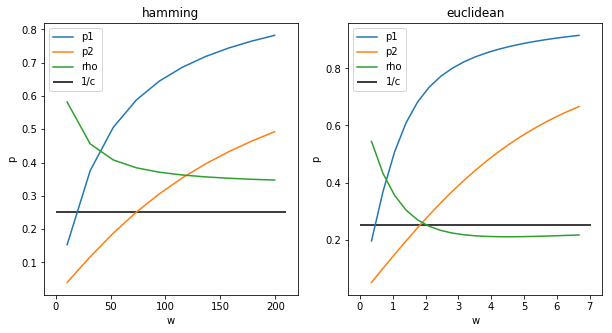

In [89]:
tle2lsh_param.draw_W(c1=4,c2=4)

In [90]:
tle2lsh_param.set_param(125, 2.5, delta=0.1)
tle2lsh_param.generate_auxiliary_vector()

For Hamming
w1 = 125
p1 = 0.7018, p2 = 0.3736, rho = 0.3597
k1 = 10
For Euclidean
w2 = 2.5
p1 = 0.7756, p2 = 0.3330, rho = 0.2311
k2 = 9
L1 = 79, L2 = 22


In [91]:
%%time
buckets = TLE2LSH_process(tle2lsh_param)

CPU times: user 1min 19s, sys: 280 ms, total: 1min 19s
Wall time: 1min 19s


In [92]:
size = 0
for bucket in buckets:
    for bu in bucket:
        for key, b in bu.items():
            size += sys.getsizeof(key)
            size += sys.getsizeof(b)
size / mbyte

56.24335289001465

In [82]:
print(metrics.__doc__)


    Desc:
        评估
            1. 查询到最近邻的概率
            2. 准确率(现更改为错误率 error_ratio)
            3. 召回率
            4. 候选集数量(现改成 selectivity, 候选数量/数据集大小)
            5. 哈希时间
            6. 查询时间(最近邻)
            7. 空间消耗由于不同方法存储结构不同，放至函数体外
    Args:
        P: 数据集
        query_func: 查询函数
        args: 查询函数所需参数
        test: 测试集
        exact_nearest_neighbor: 精确的最近邻
        exact_k_near_neighbors: 精确的k-近邻
    


In [93]:
%%time
metrics(train, TLE2LSH_query, [tle2lsh_param, buckets], 
        test[:100], 
        dic_nearest_neighbor[dataset_title], 
        dic_k_near_neighbors[dataset_title])

ZeroDivisionError: division by zero

In [ ]:
std_acc = hybird_std_accuracy(train, TLE2LSH_query, [tle2lsh_param, buckets], 
                test_P=test[:50], test_name=name)
f1 = 2 * rc * std_acc / (rc + std_acc)

print('std_acc = {}, f1 score = {}'.format(std_acc, f1))